# 프로젝트 : 번역가는 대화에도 능하다

## 1. 데이터 준비하기

## 2. 모델 설계하기

## 3. 모델 학습하기

## 4. BLEU 스코어 측정하기

In [1]:
#!pip install --upgrade gensim==3.8.3

In [2]:
import numpy 
import pandas 
import tensorflow 
import nltk
import gensim

print(numpy.__version__)
print(pandas.__version__)
print(tensorflow.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


- - -
### 데이터 준비하기

In [3]:
import os, re, math
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

data_path = os.getenv('HOME') + '/aiffel/GoingDeeper/dataset/ChatbotData.csv'
data = pd.read_csv(data_path, encoding='UTF-8')

data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


### *특수 문자 제거*

In [4]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([\"#$%&\'()*+-/:;<=>@[\]^_`{|}~])", "", sentence) # 특수문자 제거(일부 예외 처리함)
    sentence = re.sub(r"([?!,.])", r" \1 ", sentence) # 예외 처리한 특수문자들 주변에 공백 추가)
    sentence = re.sub(r"[' ']+", " ", sentence) # 여러 개의 공백은 하나의 공백으로

    sentence = sentence.strip()
    
    return sentence

questions = []
answers = []

for i in range(len(data)):
    questions.append(preprocess_sentence(data['Q'][i]))
    answers.append(preprocess_sentence(data['A'][i]))

In [5]:
print(len(questions))
print(len(answers))

11823
11823


데이터를 정제하면서 질문과 답변 리스트로 나눠줬습니다.

### *중복 제거*

In [6]:
# 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다.
# 중복 쌍이 흐트러지지 않도록 유의하세요!

idx_questions = {v: i for i, v in enumerate(questions)}
idx_answers = {v: i for i, v in enumerate(answers)}

print(len(idx_questions))
print(len(idx_answers))

set_index = set(idx_questions.values()) & set(idx_answers.values())

print(len(set_index))

11640
7773
7700


딕셔너리는 키 값이 중복되지 않는다는 것을 이용해 `문장 : 인덱스`로 각 리스트의 중복을 제거하고

질문 인덱스와 답변 인덱스의 교집합을 이용해 중복을 병렬로 제거한 결과 *7700*개의 데이터가 남았습니다.

In [7]:
questions = [questions[i] for i in set_index]
answers = [answers[i] for i in set_index]

for i in range(30):
    print(questions[i])
    print(answers[i])
    print()

3박4일 정도 놀러가고 싶다
여행은 언제나 좋죠

sd카드 안돼
다시 새로 사는 게 마음 편해요

sns 시간낭비인데 자꾸 보게됨
시간을 정하고 해보세요

가끔 뭐하는지 궁금해
그 사람도 그럴 거예요

가스불 켜놓고 나온거 같아
빨리 집에 돌아가서 끄고 나오세요

가스비 장난 아님
다음 달에는 더 절약해봐요

가족들이랑 서먹해졌어
다들 바빠서 이야기할 시간이 부족했나봐요

가족들이랑 어디 가지 ?
온 가족이 모두 마음에 드는 곳으로 가보세요

가족여행 가야지
더 가까워질 기회가 되겠네요

간식 추천
단짠으로 두 개 사는게 진리죠

갈까 말까 ?
가세요

감정컨트롤이 안돼
그건 습관이에요

강아지 키울 수 있을까
먼저 생활패턴을 살펴 보세요

강아지 키울까
책임질 수 있을 때 키워 보세요

개강옷 예쁘게 입어 볼까
개시해보세요

개념이 없어
그게 제일 중요한 건데요

개당황했잖아 갑자기 물어 봐서
갑작스러웠나봐요

개인적인 일도 다 시켜
공적인 일부터 하세요

거짓말을 하게 돼
거짓말은 할수록 늘어요

걱정 좀 없이 살고 싶다
누구나 걱정은 있어요

건강검진하러 옴
주기적으로 해주는 게 좋죠

건물주가 짱인데
이룰 수 있을 거예요

겁난다
용기 내보세요

게임 같이 하자고 할까 ?
안 될 것도 없죠

게임도 이제 재미없어
다른 게임해보세요

게임하고 싶어
게임하세요 !

게임하다 시간 다갔어
게임할때는 시간이 더 빨리 가요

겨울이 가고 봄이 올거야
마음에도 봄이 오길 바라요

격려가 필요해
잘하실 거예요 !

결정은 빠를수록 좋겠지 ?
자신을 위한 결정을 내리길 바라요



### *형태소 분리*

In [8]:
# 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
from konlpy.tag import Mecab

questions = [Mecab().morphs(sentence) for sentence in questions]
answers = [Mecab().morphs(sentence) for sentence in answers]

In [9]:
for i in range(10):
    print('>> ', questions[i])
    print('>> ', answers[i])
    print()

>>  ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
>>  ['여행', '은', '언제나', '좋', '죠']

>>  ['sd', '카드', '안', '돼']
>>  ['다시', '새로', '사', '는', '게', '마음', '편해요']

>>  ['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨']
>>  ['시간', '을', '정하', '고', '해', '보', '세요']

>>  ['가끔', '뭐', '하', '는지', '궁금', '해']
>>  ['그', '사람', '도', '그럴', '거', '예요']

>>  ['가스', '불', '켜', '놓', '고', '나온', '거', '같', '아']
>>  ['빨리', '집', '에', '돌아가', '서', '끄', '고', '나오', '세요']

>>  ['가스', '비', '장난', '아님']
>>  ['다음', '달', '에', '는', '더', '절약', '해봐요']

>>  ['가족', '들', '이랑', '서먹', '해졌', '어']
>>  ['다', '들', '바빠서', '이야기', '할', '시간', '이', '부족', '했', '나', '봐요']

>>  ['가족', '들', '이랑', '어디', '가', '지', '?']
>>  ['온', '가족', '이', '모두', '마음', '에', '드', '는', '곳', '으로', '가보세요']

>>  ['가족', '여행', '가야지']
>>  ['더', '가까워질', '기회', '가', '되', '겠', '네요']

>>  ['간식', '추천']
>>  ['단', '짠', '으로', '두', '개', '사', '는', '게', '진리', '죠']



KoNLPy의 Mecab을 불러와서 모든 문장에 대해 형태소 분리를 진행했습니다.

### *필터링*

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


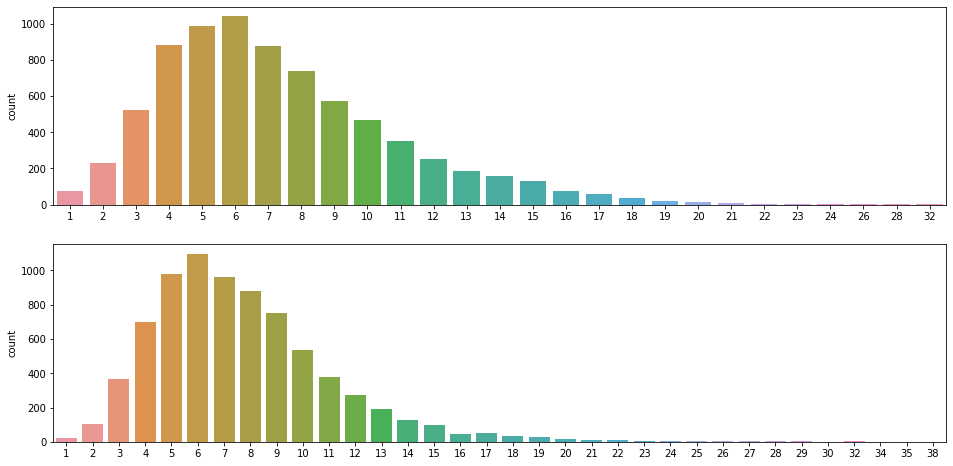

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot([len(i) for i in questions])
plt.subplot(212)
sns.countplot([len(i) for i in answers])
plt.show()

형태소 분리 후 데이터의 길이 분포입니다.

In [11]:
# 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
min_len = 2
max_len = 13

que_corpus = []
ans_corpus = []

for q, a in zip(questions, answers):
    if min_len < len(q) < max_len and min_len < len(a) < max_len:
        que_corpus.append(q)
        ans_corpus.append(a)

print(len(que_corpus))
print(len(ans_corpus))

6060
6060


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


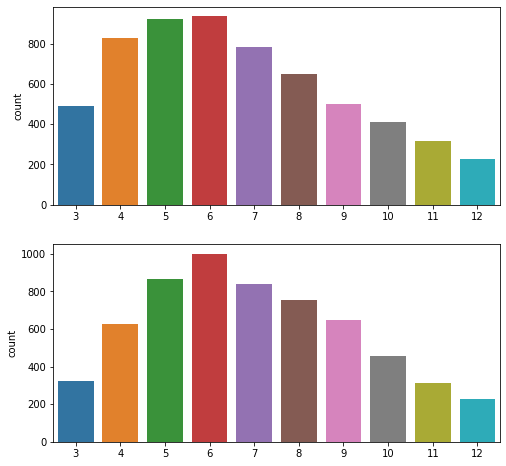

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
sns.countplot([len(i) for i in que_corpus])
plt.subplot(212)
sns.countplot([len(i) for i in ans_corpus])
plt.show()

길이가 3 이상 12 이하인 문장들로만 구성된 6060개의 데이터가 남았습니다.

### *Augmentation*

In [13]:
import gensim

word2vec_path = os.getenv('HOME') + '/aiffel/GoingDeeper/dataset/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec.wv.most_similar("강아지")

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

`gensim.models`로 한글 Word2Vec 파일을 불러와줍니다.

    해당 프로젝트의 클라우드에선 gensim의 버전이 4.0 이상으로 준비되어 있으나
    한글 Word2Vec 파일을 불러오는 데 오류가 생겨 gensim 3.8.3 버전을 설치했습니다.

In [14]:
test_sentence_count = len(que_corpus) // 100

que_corpus = que_corpus[:-test_sentence_count]
ans_corpus = ans_corpus[:-test_sentence_count]

test_que_corpus = que_corpus[-test_sentence_count:]
test_ans_corpus = ans_corpus[-test_sentence_count:]

print(len(que_corpus))
print(len(test_que_corpus))

6000
60


데이터를 불리기 전 데이터셋의 1% 만큼을 테스트용 데이터셋으로 나눠줬습니다.

테스트용 데이터셋은 원본 그대로의 데이터로 검증을 하고 싶어서

데이터셋을 불리기 전에 미리 나눠주고 훈련용 데이터셋에만 진행해주겠습니다.

In [15]:
# Lexical Substitution 구현하기
import random

def lexical_sub(sentence, word2vec):
    i = 0
    while True:
        try:
            _from = random.choice(sentence)
            _to = word2vec.wv.most_similar(_from)[i][0]
            
            sentence = [_to if tok is _from else tok for tok in sentence]
            # 선택된 단어가 문장 안에 여러 번 등장해도 하나만 변경되지 않게 모두 처리
            return sentence
        
        except:   # 단어장에 없으면 다음으로 유사한 단어
            i += 1
            if i > 100:
                return None # 무한 루프 탈출

`while True`와 `try`, `except`을 이용해 먼저 선택된 단어가 Word2Vec 파일에 준비되지 않은 단어여도

다음으로 유사한 단어를 검색해 할당하도록 시도해봤습니다.

모든 단어가 파일에 없는 단어일 경우를 대비해 약 100번의 시도 후 반복문을 탈출하도록 했습니다.

In [16]:
print(que_corpus[0])
print(lexical_sub(que_corpus[0], word2vec))

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
['3', '박', '4', '일', '정도', '놀', '러', '가', '기에', '싶', '다']


함수에 토큰화된 상태의 문장을 입력으로 넣으면 무작위로 하나의 토큰이 비슷한 단어로 변경되어 출력됩니다.

In [17]:
new_corpus = []

for i in tqdm(range(len(que_corpus))):
    old_src = que_corpus[i]
    old_tgt = ans_corpus[i]
    new_src = lexical_sub(old_src, word2vec)
    new_tgt = lexical_sub(old_tgt, word2vec)
    new_corpus.append((old_src, old_tgt))
    if new_src is not None: new_corpus.append((new_src, old_tgt))
    if new_tgt is not None: new_corpus.append((old_src, new_tgt))
    if new_src is not None and new_tgt is not None: new_corpus.append((new_src, new_tgt))

que_corpus, ans_corpus = zip(*new_corpus)

for i in range(16):
    print(que_corpus[i])
    print(ans_corpus[i])
    print()

  0%|          | 0/6000 [00:00<?, ?it/s]

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
['여행', '은', '언제나', '좋', '죠']

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '겠', '다']
['여행', '은', '언제나', '좋', '죠']

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
['여행', '은', '언제나', '괜찮', '죠']

['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '겠', '다']
['여행', '은', '언제나', '괜찮', '죠']

['sd', '카드', '안', '돼']
['다시', '새로', '사', '는', '게', '마음', '편해요']

['sd', '단말기', '안', '돼']
['다시', '새로', '사', '는', '게', '마음', '편해요']

['sd', '카드', '안', '돼']
['다시', '새로', '타', '는', '게', '마음', '편해요']

['sd', '단말기', '안', '돼']
['다시', '새로', '타', '는', '게', '마음', '편해요']

['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨']
['시간', '을', '정하', '고', '해', '보', '세요']

['sns', '간격', '낭비', '인데', '자꾸', '보', '게', '됨']
['시간', '을', '정하', '고', '해', '보', '세요']

['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨']
['분간', '을', '정하', '고', '해', '보', '세요']

['sns', '간격', '낭비', '인데', '자꾸', '보', '게', '됨']
['분간', '을', '정하', '고', '해', '보', '세요']

['가끔', '뭐', '하', '는지', '궁금', '해']
['그', 

- `원본 질문 : 원본 답변`
- `원본 질문 : 수정본 답변`
- `수정본 질문 : 원본 답변`
- `수정본 질문 : 수정본 답변`

으로 원래의 데이터셋 크기에서 약 4배로 늘어나도록 했습니다.

In [18]:
print(len(que_corpus))
print(len(ans_corpus))

23964
23964


훈련용 데이터가 *6000*개에서 약 *24000*개로 늘어났습니다.

### *벡터화*

In [19]:
def Tokenize(src, tgt, max_len):
    tensor = []
    
    for sentence in src:
        tensor.append(sentence)
    
    for sentence in tgt:
        tensor.append(["<start>"] + sentence + ["<end>"])
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(tensor)
    tensor = tokenizer.texts_to_sequences(tensor)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    
    src_corpus = tensor[:len(src)]
    tgt_corpus = tensor[len(tgt):]
    
    return src_corpus, tgt_corpus, tokenizer

In [20]:
MAX_LEN = 14

enc_train, dec_train, tokenizer = Tokenize(que_corpus, ans_corpus, MAX_LEN)

print(enc_train.shape)
print(dec_train.shape)
print('단어장의 크기 :', len(tokenizer.word_index))

(23964, 14)
(23964, 14)
단어장의 크기 : 6675


저는 최대 길이가 12 이하인 문장들로 분류해줬기 때문에 `<start>` 토큰과 `<end>` 토큰을 추가한

길이 14를 `MAX_LEN`으로 설정했습니다.

In [21]:
for i in range(16):
    print('>> ', enc_train[i])
    print('>> ', [tokenizer.index_word[word] for word in enc_train[i] if word != 0])
    print('>> ', dec_train[i])
    print('>> ', [tokenizer.index_word[word] for word in dec_train[i] if word != 0])
    print()

>>  [ 241 2457  508   57  383  290  266    7   10   37   34    0    0    0]
>>  ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
>>  [  1 348  13 559  12  29   2   0   0   0   0   0   0   0]
>>  ['<start>', '여행', '은', '언제나', '좋', '죠', '<end>']

>>  [ 241 2457  508   57  383  290  266    7   10   23   34    0    0    0]
>>  ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '겠', '다']
>>  [  1 348  13 559  12  29   2   0   0   0   0   0   0   0]
>>  ['<start>', '여행', '은', '언제나', '좋', '죠', '<end>']

>>  [ 241 2457  508   57  383  290  266    7   10   37   34    0    0    0]
>>  ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다']
>>  [  1 348  13 559  75  29   2   0   0   0   0   0   0   0]
>>  ['<start>', '여행', '은', '언제나', '괜찮', '죠', '<end>']

>>  [ 241 2457  508   57  383  290  266    7   10   23   34    0    0    0]
>>  ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '겠', '다']
>>  [  1 348  13 559  75  29   2   0   0   0   0   0   0   0]
>>  ['<start>', '여행', '은', '언제나', '괜찮', '

- - -
### 모델 설계하기

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 24000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE).batch(batch_size=BATCH_SIZE)

In [23]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [24]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [25]:
# Multi Head Attention 구현

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [26]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='gelu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

gelu

In [27]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [28]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [29]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [30]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [31]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.drop = dropout
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

- - -
### 모델 학습하기

In [32]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
d_model = 368

transformer = Transformer(
    n_layers=1,
    d_model=d_model,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=32,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

In [33]:
# Learning Rate Scheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [34]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [35]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [36]:
def translate(tokens, model, tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        if predicted_id == tokenizer.word_index['<end>']:
            result = [tokenizer.index_word[i] for i in ids]
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = [tokenizer.index_word[i] for i in ids]
    
    return result

In [37]:
examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

def ChatBot(inputs, model, tokenizer):
    sentence = preprocess_sentence(inputs)
    sentence = Mecab().morphs(sentence)
    tokens = tokenizer.texts_to_sequences([sentence])
    
    candidate = ' '.join(translate(tokens, model, tokenizer))
    
    print('Q :', inputs)
    print('A :', candidate)

In [38]:
# 훈련시키기
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
    
    for ex in examples:
        ChatBot(ex, transformer, tokenizer)
        print()
    
    print('Loss :', (total_loss.numpy() / (step + 1)))
    print('Epoch At :', epoch + 1)

print('='*50)
print('Hyperparameters')
print('> n_layers :', transformer.encoder.n_layers)
print('> d_model :', d_model)
print('> n_heads :', transformer.n_heads)
print('> d_ff :', transformer.d_ff)
print('> dropout :', transformer.drop)
print()

print('Training Parameters')
print('> Warmup Steps :', learning_rate.warmup_steps)
print('> Batch Size :', BATCH_SIZE)

  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 같이 놀 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 내일 은 날 이 었 나 봐요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 친구 가 되 는 게 좋 을 것 같 아요

Q : 집에 있는다는 소리야.
A : 생각 을 정리 하 는 것 도 좋 겠 어요

Loss : 4.802348958333333
Epoch At : 1


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 같이 이야기 해 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 신경 쓰 지 않 을 끄 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 함께 데이트 데이트 놀드 좋 겠 네요

Q : 집에 있는다는 소리야.
A : 가지마 요

Loss : 2.1135735677083334
Epoch At : 2


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 누구 나 같 아요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 아직 미련 이 남 지 않 아요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 자신 의 기본 이 있 냐고 물 어 보 세요

Q : 집에 있는다는 소리야.
A : 가지마 요

Loss : 1.347933349609375
Epoch At : 3


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 친구 들 를 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 내일 피곤 하 신가 봐요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 친구 를 맞춰 보 세요

Q : 집에 있는다는 소리야.
A : 내 집 죠

Loss : 0.9497384440104166
Epoch At : 4


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 주기 적 으로 해 주 지 면 좋 아요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 부터 하 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 마음 를 함께 하 는 건 좋 은 이곳 이 죠

Q : 집에 있는다는 소리야.
A : 내 집 마련 이 죠

Loss : 0.6832029622395833
Epoch At : 5


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 를 떠나 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 부터 만드세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 척 하 는 것 도 없 겠 어요

Q : 집에 있는다는 소리야.
A : 눈치 는 추억 이 되 겠 네요

Loss : 0.5513205973307291
Epoch At : 6


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 를 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 작 은 일 에 도 필요 하 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 친구 를 먼저 기억 하 겠 죠

Q : 집에 있는다는 소리야.
A : 새로운 친교 를 찾아보 세요

Loss : 0.4759049072265625
Epoch At : 7


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 친구 과 잘 놀 러 가 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 좀 더 일찍 잠자리 에 고민 이 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 친구 를 뒀 네요

Q : 집에 있는다는 소리야.
A : 새로운 관계 를 찾아보 세요

Loss : 0.42131892903645835
Epoch At : 8


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 를 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 은 복 스럽 게 만들 어서 먹 어 보 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 상처 받 는다고 꼭 엄청 할 때 같 습니다

Q : 집에 있는다는 소리야.
A : 회사 에서 연인 가 는 곳 으로 가보세요

Loss : 0.3790906575520833
Epoch At : 9


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 누구 와 같이 살 아요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 그분 생각 으로 가득 한가 봐요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 결혼 준비 하 는 마음 이 복잡 하 겠 어요

Q : 집에 있는다는 소리야.
A : 새로운 친교 를 만들 면 돼요

Loss : 0.347474853515625
Epoch At : 10


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 제 가 놀 때 저 도 데려가 주 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 은 자기 을 받아들이 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 모두 맞춰 가 본 곳 으로 가보세요

Q : 집에 있는다는 소리야.
A : 생각 보다 불편 하 겠 네요

Loss : 0.3214365234375
Epoch At : 11


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 친구 를 맞이 할 준비 해 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 은 사랑 하 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 그런 척 하 는 걸 수 도 있 어요

Q : 집에 있는다는 소리야.
A : 이기 적 이 네요

Loss : 0.29984674072265627
Epoch At : 12


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 를 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 뭘 하 지 않 으면 좋 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 연인 과 함께 했 던 걸 수 도 있 어요

Q : 집에 있는다는 소리야.
A : 이기 적 이 네요

Loss : 0.2823822021484375
Epoch At : 13


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 를 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 휴식 을 취해 보 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 헤어짐 에 는 곳 이 있 었 을 거 예요

Q : 집에 있는다는 소리야.
A : 집 에서 숀 는 시간 도 필요 해요

Loss : 0.26738667805989585
Epoch At : 14


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 제 가 놀 다 오 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 뭘 먹 든 맛있 게 드세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 알 면 화날 거 예요

Q : 집에 있는다는 소리야.
A : 생각 보다 큰 도움 이 될 것 같 아요

Loss : 0.2523057861328125
Epoch At : 15


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 을 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 미련 이 남 지 않 을 거 예요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 치명상 받 았 으면 좋 겠 네요

Q : 집에 있는다는 소리야.
A : 새로운 친교 를 찾아보 세요

Loss : 0.2415555419921875
Epoch At : 16


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 같이 놀 러 다니 자고 해봐요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 미련 을 남기 고 쉬 어 보 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 모두 를 데이트 하 셨 군요

Q : 집에 있는다는 소리야.
A : 용기 를 내 서 고백 을 해봐요

Loss : 0.22958644612630208
Epoch At : 17


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 을 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 뭘 잘못 주무셨 나 봐요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 상처 받 았 으면 좋 겠 네요

Q : 집에 있는다는 소리야.
A : 새로운 관계 를 끝내 는 건 없 죠

Loss : 0.22027665201822916
Epoch At : 18


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여행 을 떠나 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 은 자기 을 위해 에너지 를 가 필요 하 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 만남 이 되 길 바랄 게요

Q : 집에 있는다는 소리야.
A : 새로운 관계 를 유지 하 세요

Loss : 0.21240749104817708
Epoch At : 19


  0%|          | 0/375 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 안 고 있 다면 지금 같이 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 내일 은 나 면 더 그리울 거 예요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 곳 이 었 겠 네요

Q : 집에 있는다는 소리야.
A : 용기 내 서 먼저 다가가 보 세요

Loss : 0.20373311360677082
Epoch At : 20
Hyperparameters
> n_layers : 1
> d_model : 368
> n_heads : 8
> d_ff : 1024
> dropout : 0.2

Training Parameters
> Warmup Steps : 1000
> Batch Size : 64


파라미터 설정은 예제의 예시를 그대로 따라하고 20Epochs 학습을 진행한 결과입니다.

매 epoch 시마다 예문을 모델에 입력으로 넣었지만 썩 마음에 드는 답변을 한 결과는 없습니다.

- - -
### BLEU 스코어 측정하기

In [39]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [40]:
def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, verbose=True):
    src_tokens = tokenizer.texts_to_sequences([src_sentence])
    tgt_tokens = tokenizer.texts_to_sequences([tgt_sentence])

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None
    
    reference = ' '.join(tgt_sentence)
    candidate = ' '.join(translate(src_tokens, model, tokenizer))
    
    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)
    
    if verbose:
        print("Source Sentence: ", ' '.join(src_sentence))
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [41]:
def eval_bleu(model, src_sentences, tgt_sentence, tokenizer, verbose=False):
    total_score = 0.0
    sample_size = len(src_sentences)
    verbose_ = verbose
    
    tqdm_bar = tqdm(total=sample_size)
    
    for idx in range(sample_size):
        if verbose:
            verbose_ = True if (idx+1) % verbose == 0 else False # verbose 로 설정한 값을 스텝으로 결과를 출력
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], tokenizer, verbose_)
        if not score: continue
        
        total_score += score
        
        tqdm_bar.set_postfix_str('Bleu %.4f' % (total_score / (idx + 1)))
        tqdm_bar.update()
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

verbose에 True가 아닌 정수값을 넣어서 정수의 스텝마다 예측 결과를 출력하도록 함수를 생성했습니다.

In [42]:
eval_bleu(transformer, test_que_corpus, test_ans_corpus, tokenizer, verbose=5)

  0%|          | 0/60 [00:00<?, ?it/s]

Source Sentence:  차 로 데려다 줬 는데
Model Prediction:  고마움 을 전해 보 세요
Real:  고마움 을 전해 보 세요
Score: 1.000000

Source Sentence:  처음 마음 이 아픈 게 첫 사랑 인가
Model Prediction:  이루 어 꼼짝 지 않 은 사랑 은 모두 아프 죠
Real:  이루 어 지 지 않 은 사랑 은 모두 아프 죠
Score: 0.853141

Source Sentence:  첫 데이트 어디 로 가 는 게 좋 을까 ?
Model Prediction:  공원 이나 익숙 한 이곳 을 가보세요
Real:  공원 이나 익숙 한 곳 을 가보세요
Score: 0.857893

Source Sentence:  첫 사랑 을 다시 만났 어
Model Prediction:  새로운 사랑 의 시작 이 되 길 바라 요
Real:  새로운 사랑 의 시작 이 되 길 바라 요
Score: 1.000000

Source Sentence:  청첩장 누구 한테 줘야 할지
Model Prediction:  그게 제일 고민 이 죠
Real:  그게 제일 고민 이 죠
Score: 1.000000

Source Sentence:  취 준 생 인데 연애 해도 될까 ?
Model Prediction:  취업 이랑 연애 둘 다 잘 할 수 있 을 거 예요
Real:  취업 이랑 연애 둘 다 잘 할 수 있 을 거 예요
Score: 1.000000

Source Sentence:  친구 짝 녀 가 날 좋 아 하 는 데 어쩔
Model Prediction:  모르 ㄴ다는 척 하 는 게 나을 수 도 있 겠 어요
Real:  모르 는 척 하 는 게 나을 수 도 있 겠 어요
Score: 0.864571

Source Sentence:  친구 들 이 사랑 하 니까 예뻐졌 대
Model Prediction:  행복 바이러스 것들 감염 되 셨 군요
Real:  행복 바이러스 에 감염 되 셨 군요
Score: 0.803155

Source Sent

테스트용 데이터 60개를 예측했더니 Bleu 스코어가 예상보다 높은 스코어를 달성했습니다.

In [43]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [44]:
# beam_search_decoder() 구현
def beam_search_decoder(sentence,
                        model,
                        tokenizer,
                        beam_size):
    
    tokens = tokenizer.texts_to_sequences([sentence])
    src_in = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                            maxlen=MAX_LEN,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, MAX_LEN), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, MAX_LEN), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tokenizer.word_index['<start>']

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, MAX_LEN):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tokenizer.word_index['<end>']:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        if tokenizer.word_index['<end>'] in long_pred.tolist():
            zero_idx = long_pred.tolist().index(tokenizer.word_index['<end>'])
            short_pred = long_pred[:zero_idx+1]
        else:
            short_pred = long_pred
            
        pred.append(short_pred)
        
    return pred

In [45]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

In [46]:
# beam_bleu() 구현
def beam_bleu(reference, ids, tokenizer):
    total_score = 0.0
    
    for _id in ids:
        candidate = [tokenizer.index_word[i] for i in _id if i != tokenizer.word_index['<end>']][1:]
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", score)

        total_score += score
        
    return total_score / len(ids)

In [47]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 9

ids = \
beam_search_decoder(test_que_corpus[test_idx],
                    transformer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_ans_corpus[test_idx], ids, tokenizer)
print(bleu)

Reference: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
Candidate: ['이루', '어', '꼼짝', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
BLEU: 0.7419446627365011
Reference: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
Candidate: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
BLEU: 1.0
Reference: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
Candidate: ['이루', '어', '보', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
BLEU: 0.7419446627365011
Reference: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
Candidate: ['이루', '어', '하', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
BLEU: 0.7419446627365011
Reference: ['이루', '어', '지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
Candidate: ['이루', '어', 'ㄹ지', '지', '않', '은', '사랑', '은', '모두', '아프', '죠']
BLEU: 0.7419446627365011
0.7935557301892008


빔서치를 이용해 Bleu 점수를 높이는 방법입니다.

In [48]:
# beam_bleu() 구현
def beam_bleu_most(reference, ids, tokenizer):
    result = []
    
    for k, _id in enumerate(ids):
        candidate = [tokenizer.index_word[i] for i in _id if i != tokenizer.word_index['<end>']][1:]
        score = calculate_bleu(reference, candidate)
        
        result.append({
            "Reference" : reference,
            "Candidate" : candidate,
            "BLEU" : score
            })
        
    result = sorted(result, key=lambda x: x['BLEU'], reverse=True)[0]
    
    return result

빔서치를 이용해 생성한 문장 중에서 가장 높은 Bleu 스코어를 가진 문장을 출력하도록 함수를 생성했습니다.

In [56]:
total_bleu = 0
tqdm_bar = tqdm(total=len(test_que_corpus))

for i in range(len(test_que_corpus)):
    ids = \
    beam_search_decoder(test_que_corpus[i],
                        transformer,
                        tokenizer,
                        beam_size=5)
    most_score = beam_bleu_most(test_ans_corpus[i], ids, tokenizer)
    
    print("Source:", test_que_corpus[i])
    print("Reference:", most_score['Reference'])
    print("Candidate:", most_score['Candidate'])
    print("BLEU:", most_score['BLEU'])
    print()
    
    total_bleu += most_score['BLEU']
    
    tqdm_bar.set_postfix_str('Bleu %.4f' % (total_bleu / (i + 1)))
    tqdm_bar.update()

print("="*100)
print("Total Score:", total_bleu / len(test_que_corpus))

  0%|          | 0/60 [00:00<?, ?it/s]

Source: ['짝사랑', '하', '다고', '솔', '탈함', '기', '받', '아가']
Reference: ['기', '받', '아', '갈게요']
Candidate: ['기', '받', '아', '갈게요']
BLEU: 1.0

Source: ['짝사랑', '하', '면', '어떤', '기분', '이', '야', '?']
Reference: ['혼자', '서', '설레', '고', '혼자', '헤어지', '는', '기분', '이', '에요']
Candidate: ['혼자', '서', '설레', '고', '혼자', '사귀', '는', '기분', '이', '에요']
BLEU: 0.6580370064762462

Source: ['짝사랑', '한', '만큼', '상처', '도', '깊', '어', '져']
Reference: ['상처', '가', '아무', '는', '덴', '시간', '이', '걸릴지', '도', '몰라요']
Candidate: ['상처', '가', '아무', '는', '덴', '시간', '이', '걸릴지', '도', '몰라요']
BLEU: 1.0

Source: ['차', '없', '으면', '데이트', '못', '해', '?']
Reference: ['걸어다니', '면서', '하', '는', '데이트', '가', '진정한', '데이트', '죠']
Candidate: ['걸어다니', '면서', '하', '는', '데이트', '가', '진정한', '데이트', '죠']
BLEU: 1.0

Source: ['차', '로', '데려다', '줬', '는데']
Reference: ['고마움', '을', '전해', '보', '세요']
Candidate: ['고마움', '을', '전해', '보', '세요']
BLEU: 1.0

Source: ['차였', '는데', '좋', '아', '하', '는', '감정', '이', '사라지', '질', '않', '아요']
Reference: ['정말', '많이', '좋', '아', '했', '나', '봐요']
Ca

Source: ['친구', '의', '친구', '를', '사랑', '했', '네']
Reference: ['슬픈', '이야기', '네요']
Candidate: ['슬픈', '이야기', '네요']
BLEU: 0.5623413251903491

Source: ['친구', '인데', '고백', '해도', '될까', '?']
Reference: ['솔직', '한', '마음', '으로', '다가가', '보', '세요']
Candidate: ['솔직', '한', '마음', '으로', '다가가', '보', '세요']
BLEU: 1.0

Source: ['친한', '동생', '인데', '짝', '녀', '가', '된', '것', '같', '아요']
Reference: ['있', '을', '수', '있', '는', '일', '이', '에요']
Candidate: ['있', '을', '수', '있', '는', '일', '이', '에요']
BLEU: 1.0

Source: ['친한', '동생', '인데', '짝사랑', '하', '는', '것', '같', '습니다']
Reference: ['남녀', '사이', '에서', '있', '을', '수', '있', '는', '일', '입니다']
Candidate: ['남녀', '사이', '에서', '있', '을', '수', '있', '는', '일', '입니다']
BLEU: 1.0

Source: ['친한', '친구', '가', '저', '를', '좋아하', '는', '것', '같', '아요']
Reference: ['친구', '사이', '가', '깨', '질까', '걱정', '되', '나', '봐요']
Candidate: ['친구', '사이', '가', '깨', '질까', '걱정', '되', '나', '봐요']
BLEU: 1.0

Source: ['친한', '친구', '의', '구', '남친', '이랑', '사귀', '어도', '될까요', '?']
Reference: ['친한', '사이', '가', '아니', '라면', '괜찮', '지만',

아까처럼 60개의 테스트용 데이터를 예측한 결과 정확도가 거의 100%에 가깝게 나왔습니다.

In [57]:
ChatBot('솔직히 기대 이상이야.', transformer, tokenizer)

Q : 솔직히 기대 이상이야.
A : 서로 에게 부담 없 지 않 는 으세요


In [58]:
ChatBot('정해진 답변 밖에 못하는거니?', transformer, tokenizer)

Q : 정해진 답변 밖에 못하는거니?
A : 술 은 끊 는 게 힘들 죠


In [59]:
ChatBot('갑자기 실망스러워지려고 해.', transformer, tokenizer)

Q : 갑자기 실망스러워지려고 해.
A : 기대 가 없 나 봐요


In [60]:
ChatBot('그래도 여전히 기대 이상이야', transformer, tokenizer)

Q : 그래도 여전히 기대 이상이야
A : 이별 의 끝 은 항상 그런가 봐요


In [61]:
ChatBot('아까 한 말은 취소.', transformer, tokenizer)

Q : 아까 한 말은 취소.
A : 어떻게 든 참 는 사람 은 이제 남 죠


In [62]:
ChatBot('너 유머 감각 꽝이야.', transformer, tokenizer)

Q : 너 유머 감각 꽝이야.
A : 안 가 본 건 궁금 해요


마지막으로 챗봇과 대화를 시도해봤습니다.

점수가 높게 나왔던 것에 비해 실제로 자연스러운 대화를 하기에는 아직 부족한 것 같습니다.

데이터셋이 적다보니 준비된 데이터에 대해서는 높은 성능을 보여주더라도 임의로 생성한 문장은 아직 읽을 수 없나 봅니다.

- - -
## 마무리하며

### *컨셉*

이번 프로젝트는 좀 색다른 느낌을 받고 싶어서 `pandas`와 `numpy` 모듈을 최대한 안써보려고 노력했습니다.

LMS에서도 모듈을 쓰지 않고 지시를 따르도록 유도하는 듯한 뉘앙스도 있기도 했구요.

### *느낀점*

모듈을 쓰지 않고 중복을 병렬로 제거하는 좋은 방법을 찾아내려고 1시간의 고민 끝에 3줄의 코드가 탄생했습니다.

비록 1시간이 담긴 3줄이였지만 복잡하지도 않으면서 무사히 중복을 제거하는 코드를 찾았다는 것이 아직도 뿌듯합니다.

전체적으로 함수를 본인의 입맛대로 수정하고 생성해야 하는 과제가 많았는데 그 과정에서 난이도가 조금 있었던 프로젝트인 것 같습니다.

하이퍼파라미터는 이리저리 만져보다가 결국 예제에 나온 설정을 그대로 따라하니 성능이 가장 좋게 나왔다는 사실에 맥이 빠지긴 했습니다.

최종 결과는 BLEU 스코어가 너무 높게 나와서 제가 함수를 잘못 만들었나 싶었네요.

성능이 너무 잘나와서 만약 데이터셋의 크기가 컸다면 직접 대화까지도 가능하지 않았을까 싶기도 합니다.

### *의문점*

중복 제거 지시에 따르면 `질문 : 답변` 쌍이 중복인 데이터만 제거하는 것이 아니라

질문은 질문끼리, 답변은 답변끼리 중복을 제거하라고 나와있었는데요.

그 이후에 데이터 Augmentation을 하게 되면 다시 질문과 질문, 답변과 답변의 중복이 발생하게 됩니다.

그렇게 되면 이 중복도 제거를 해야할까? 데이터의 다양성을 늘리기 위해 중복을 생성해야 한다면

기존의 중복 제거는 쌍으로 중복되는 것만 제거하면 안됐던걸까?

그렇지 안아도 적은 데이터에 중복 조건을 크게 잡으니 7700개 밖에 남지 않는데 말이죠.

- - -
트랜스포머 모델에 넣는 `VOCAB_SIZE`를 단어장의 크기에서 +1을 해주지 않으면 학습도중에 loss가 nan이 되어버리는 오류가 있었습니다.

처음에 `VOCAB_SIZE`를 단어장의 크기 그대로 넣다가 오류가 발생하고 단어장의 크기에서 +1을 해주니까 오류가 해결되는 것은 알겠는데

아직도 오류가 났던 원인이 정확히 무엇인진 모르겠습니다.

하나 추측하고 있는 것은 단어장에 패딩의 값을 추가한 것이라고 생각할 수 있는데요.

그게 어떻게 loss가 nan이 되는 것으로 연결되는 것인지는 아직도 설명하지 못하겠습니다.